STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

In [1]:
# %load_ext watermark
# %watermark -a 'Sebastian Raschka' -v -p torch

- Runs on CPU or GPU (if available)

# Softmax Regression on MNIST

Implementation of softmax regression (multinomial logistic regression).

## Imports

In [2]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import numpy as np

## Settings and Dataset

In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.001
num_epochs = 25
batch_size = 16

# Architecture
num_features = 32*32
num_classes = 10


##########################
### MNIST DATASET
##########################

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
])



train_dataset = datasets.CIFAR10(root='./data/', 
                               train=True, 
                               transform=transform,
                               download=True)

test_dataset = datasets.CIFAR10(root='./data/', 
                              train=False, 
                              transform=transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape) #NCHW
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([16, 1, 32, 32])
Image label dimensions: torch.Size([16])


In [4]:
##########################
### MODEL
##########################

class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(device)

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [5]:
# Manual seed for deterministic data loader
torch.manual_seed(random_seed)


def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.view(-1, 32*32).to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100
    

start_time = time.time()
epoch_costs = []
for epoch in range(num_epochs):
    avg_cost = 0.
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 32*32).to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        # note that the PyTorch implementation of
        # CrossEntropyLoss works with logits, not
        # probabilities
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        avg_cost += cost
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))
            
    with torch.set_grad_enabled(False):
        avg_cost = avg_cost/len(train_dataset)
        epoch_costs.append(avg_cost)
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/025 | Batch 000/3125 | Cost: 2.3026
Epoch: 001/025 | Batch 050/3125 | Cost: 2.2806
Epoch: 001/025 | Batch 100/3125 | Cost: 2.3478
Epoch: 001/025 | Batch 150/3125 | Cost: 2.3104
Epoch: 001/025 | Batch 200/3125 | Cost: 2.2385
Epoch: 001/025 | Batch 250/3125 | Cost: 2.2564
Epoch: 001/025 | Batch 300/3125 | Cost: 2.2638
Epoch: 001/025 | Batch 350/3125 | Cost: 2.2107
Epoch: 001/025 | Batch 400/3125 | Cost: 2.2321
Epoch: 001/025 | Batch 450/3125 | Cost: 2.1852
Epoch: 001/025 | Batch 500/3125 | Cost: 2.1391
Epoch: 001/025 | Batch 550/3125 | Cost: 2.2769
Epoch: 001/025 | Batch 600/3125 | Cost: 2.0799
Epoch: 001/025 | Batch 650/3125 | Cost: 2.1597
Epoch: 001/025 | Batch 700/3125 | Cost: 2.1711
Epoch: 001/025 | Batch 750/3125 | Cost: 2.2736
Epoch: 001/025 | Batch 800/3125 | Cost: 2.1750
Epoch: 001/025 | Batch 850/3125 | Cost: 2.1457
Epoch: 001/025 | Batch 900/3125 | Cost: 2.1880
Epoch: 001/025 | Batch 950/3125 | Cost: 2.2675
Epoch: 001/025 | Batch 1000/3125 | Cost: 2.1686
Epoch: 001/0

In [6]:
ch = [t.detach().cpu().numpy() for t in epoch_costs]
arr = np.array(ch)

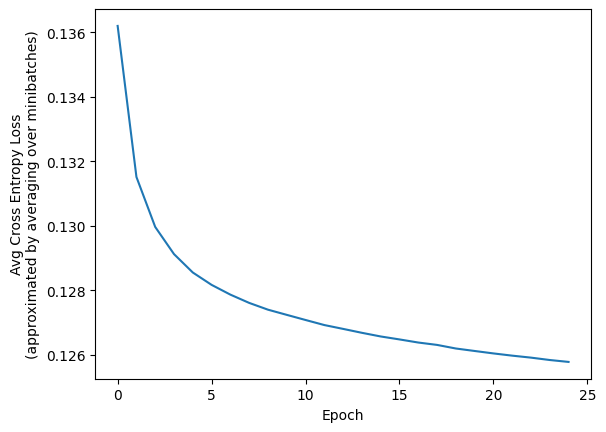

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


plt.plot(arr)
plt.ylabel('Avg Cross Entropy Loss\n(approximated by averaging over minibatches)')
plt.xlabel('Epoch')
plt.show()

In [8]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 29.64%


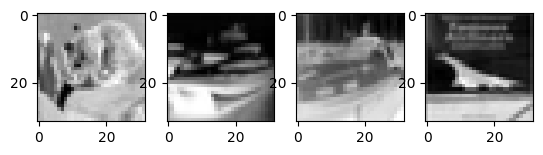

In [9]:
for features, targets in test_loader:
    break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(32, 32), cmap=matplotlib.cm.binary)

plt.show()

In [10]:
_, predictions = model.forward(features[:4].view(-1, 32*32).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([6, 9, 8, 8], device='cuda:0')


In [11]:
# Save the trained model
torch.save(model.state_dict(), './cifar10_softwmaxRegression.pth')


In [12]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
for i, (images, labels) in enumerate(test_loader):
    images = images.view(-1, num_features).to(device)
    labels = labels.to(device)
    _, predicted_labels = model(images)

    for j in range(labels.shape[0]):
        ground_truth_label = class_names[labels[j].item()]
        predicted_label = class_names[predicted_labels[j].argmax().item()]
        print(f"Image {i * batch_size + j + 1}: Ground Truth - {ground_truth_label} | Predicted - {predicted_label}")

    if len(predicted_labels) >= 6:
            break

Image 1: Ground Truth - cat | Predicted - frog
Image 2: Ground Truth - ship | Predicted - truck
Image 3: Ground Truth - ship | Predicted - ship
Image 4: Ground Truth - airplane | Predicted - ship
Image 5: Ground Truth - frog | Predicted - cat
Image 6: Ground Truth - frog | Predicted - frog
Image 7: Ground Truth - automobile | Predicted - frog
Image 8: Ground Truth - frog | Predicted - bird
Image 9: Ground Truth - cat | Predicted - airplane
Image 10: Ground Truth - automobile | Predicted - truck
Image 11: Ground Truth - airplane | Predicted - dog
Image 12: Ground Truth - truck | Predicted - truck
Image 13: Ground Truth - dog | Predicted - dog
Image 14: Ground Truth - horse | Predicted - frog
Image 15: Ground Truth - truck | Predicted - truck
Image 16: Ground Truth - ship | Predicted - ship
